In [1]:
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.3.0-posix-seh-rt_v5-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
from matplotlib import rc
rc('figure', figsize=(15, 5))
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from timeit import default_timer as timer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [3]:
sales_train = pd.read_csv(r'sales_train_v2.csv')
items = pd.read_csv(r'items.csv')
item_categories = pd.read_csv(r'item_categories.csv')
shops = pd.read_csv(r'shops.csv')
sales_test = pd.read_csv(r'test.csv')

In [4]:
sales_test['ID'] = 34
sales_test.rename({'ID': 'date_block_num'}, axis = 1, inplace = True)
sales_test = sales_test.merge(items.loc[:,['item_category_id', 'item_id']], on = 'item_id', how = 'left')

In [5]:
sales_train = sales_train.merge(items.loc[:,['item_category_id', 'item_id']], on = 'item_id', how = 'left')

Create Sales column

In [6]:
sales_train['sales'] = sales_train['item_cnt_day']*sales_train['item_price']

Aggregating the data w.r.t shop id, item id and date_block_num

In [7]:
grouped_data = sales_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({
    'item_cnt_day':sum,
    'sales':sum,
    'item_price':'median'
}).rename({'item_cnt_day': 'cnt_shop_item', 'sales': 'sales_shop_item', 'item_price': 'price_shop_item'}, axis = 1).reset_index()

Aggregating the data wrt shop_id and date_block_num

In [8]:
aggdata = sales_train.groupby(['date_block_num', 'shop_id']).agg({
    'item_cnt_day':sum,
    'sales':sum,
    'item_price':'median'
}).rename({'item_cnt_day': 'cnt_shop', 'sales': 'sales_shop', 'item_price': 'price_shop'}, axis = 1)
grouped_data = grouped_data.join(aggdata, on = ['date_block_num', 'shop_id'])

Aggregating the data wrt item_id and date_block_num

In [9]:
aggdata = sales_train.groupby(['date_block_num', 'item_id']).agg({
    'item_cnt_day':sum,
    'sales':sum,
    'item_price':'median'
}).rename({'item_cnt_day': 'cnt_item', 'sales': 'sales_item', 'item_price': 'price_item'}, axis = 1)
grouped_data = grouped_data.join(aggdata, on = ['date_block_num', 'item_id'])

Aggregating the data wrt item_category_id and date_block_num

In [10]:
grouped_data = grouped_data.merge(items[['item_id', 'item_category_id']], on = 'item_id', how = 'left')

In [11]:
aggdata = sales_train.groupby(['date_block_num', 'item_category_id']).agg({
    'item_cnt_day':sum,
    'sales':sum,
    'item_price':'median'
}).rename({'item_cnt_day': 'cnt_itcat', 'sales': 'sales_itcat', 'item_price': 'price_itcat'}, axis = 1)
grouped_data = grouped_data.join(aggdata, on = ['date_block_num', 'item_category_id'])

Appending the test data as well

In [12]:
grouped_data = grouped_data.append(sales_test, sort = False).fillna(0)

Splitting date to day, month and year

In [13]:
date_mat = sales_train.date.str.split('.', expand = True)
date_mat.columns = ['day', 'month', 'year']
date_df = pd.concat([sales_train['date_block_num'], date_mat[['month', 'year']]], axis = 1)
date_df.drop_duplicates(inplace = True)
date_df = date_df.append([{'date_block_num': 34, 'month': '11', 'year': '2015'}])

In [14]:
grouped_data = grouped_data.merge(date_df, on = 'date_block_num', how = 'left')

In [15]:
grouped_data.columns

Index(['date_block_num', 'shop_id', 'item_id', 'cnt_shop_item',
       'sales_shop_item', 'price_shop_item', 'cnt_shop', 'sales_shop',
       'price_shop', 'cnt_item', 'sales_item', 'price_item',
       'item_category_id', 'cnt_itcat', 'sales_itcat', 'price_itcat', 'month',
       'year'],
      dtype='object')

Clipping the cnt_shop_item between 0 and 20 to remove outliers

In [16]:
grouped_data['cnt_shop_item'].clip(0,20, inplace = True)

In [17]:
del aggdata

Creating Expanding Mean Encodings

In [18]:
enc_feat = ['shop_id', 'item_id', 'item_category_id', 'month', 'year']
target_feat = ['cnt_shop_item', 'cnt_shop', 'cnt_item', 'cnt_itcat']

In [19]:
enc_df = grouped_data[['date_block_num', 'shop_id', 'item_id']].copy()
for i in enc_feat:
    for j in target_feat:
        cum_sum = grouped_data.groupby(i).cumsum()[j] - grouped_data[j]
        cum_count = grouped_data.groupby(i).cumcount()
        enc_df[i+'_enc_'+j] = cum_sum/(cum_count+1)   

In [20]:
enc_df.columns

Index(['date_block_num', 'shop_id', 'item_id', 'shop_id_enc_cnt_shop_item',
       'shop_id_enc_cnt_shop', 'shop_id_enc_cnt_item', 'shop_id_enc_cnt_itcat',
       'item_id_enc_cnt_shop_item', 'item_id_enc_cnt_shop',
       'item_id_enc_cnt_item', 'item_id_enc_cnt_itcat',
       'item_category_id_enc_cnt_shop_item', 'item_category_id_enc_cnt_shop',
       'item_category_id_enc_cnt_item', 'item_category_id_enc_cnt_itcat',
       'month_enc_cnt_shop_item', 'month_enc_cnt_shop', 'month_enc_cnt_item',
       'month_enc_cnt_itcat', 'year_enc_cnt_shop_item', 'year_enc_cnt_shop',
       'year_enc_cnt_item', 'year_enc_cnt_itcat'],
      dtype='object')

Creating Lagged Features

In [39]:
lag_feat = ['sales_shop_item', 'price_shop_item', 'sales_shop', 'price_shop',  
            'sales_item', 'price_item', 'sales_itcat', 'price_itcat']
lag_df = grouped_data[['date_block_num', 'shop_id', 'item_id']]
lag_int = [1,2]
for i in lag_int:
    key_df = grouped_data[['date_block_num', 'shop_id', 'item_id']+lag_feat].copy()
    key_df['date_block_num'] = key_df['date_block_num']+i
    lag_df = lag_df.merge(key_df, on = ['date_block_num', 'shop_id', 'item_id'], how = 'left').fillna(0)
    lag_df.columns = [j + '_lag_'+ str(i) if j in lag_feat else j for j in lag_df.columns]

In [40]:
lag_feat = ['cnt_shop_item','cnt_shop', 'cnt_item', 'cnt_itcat']
lag_int = [1,2,3,4,5,6,12]
for i in lag_int:
    key_df = grouped_data[['date_block_num', 'shop_id', 'item_id'] + lag_feat].copy()
    key_df['date_block_num'] = key_df['date_block_num']+i
    lag_df = lag_df.merge(key_df, on = ['date_block_num', 'shop_id', 'item_id'], how = 'left').fillna(0)
    lag_df.columns = [j + '_lag_'+ str(i) if j in lag_feat else j for j in lag_df.columns]
del key_df

In [41]:
lag_df.columns

Index(['date_block_num', 'shop_id', 'item_id', 'sales_shop_item_lag_1',
       'price_shop_item_lag_1', 'sales_shop_lag_1', 'price_shop_lag_1',
       'sales_item_lag_1', 'price_item_lag_1', 'sales_itcat_lag_1',
       'price_itcat_lag_1', 'sales_shop_item_lag_2', 'price_shop_item_lag_2',
       'sales_shop_lag_2', 'price_shop_lag_2', 'sales_item_lag_2',
       'price_item_lag_2', 'sales_itcat_lag_2', 'price_itcat_lag_2',
       'cnt_shop_item_lag_1', 'cnt_shop_lag_1', 'cnt_item_lag_1',
       'cnt_itcat_lag_1', 'cnt_shop_item_lag_2', 'cnt_shop_lag_2',
       'cnt_item_lag_2', 'cnt_itcat_lag_2', 'cnt_shop_item_lag_3',
       'cnt_shop_lag_3', 'cnt_item_lag_3', 'cnt_itcat_lag_3',
       'cnt_shop_item_lag_4', 'cnt_shop_lag_4', 'cnt_item_lag_4',
       'cnt_itcat_lag_4', 'cnt_shop_item_lag_5', 'cnt_shop_lag_5',
       'cnt_item_lag_5', 'cnt_itcat_lag_5', 'cnt_shop_item_lag_6',
       'cnt_shop_lag_6', 'cnt_item_lag_6', 'cnt_itcat_lag_6',
       'cnt_shop_item_lag_12', 'cnt_shop_lag_12', 

Exploiting text features in item category and item names

In [42]:
n_comp = 5

In [43]:
text_feat = ['item_id', 'item_category_id']
if 'item_id' in text_feat:
    text_df = items[['item_name', 'item_id']].copy()
    tv = TfidfVectorizer()
    tv_df = tv.fit_transform(text_df['item_name'])
    svd = TruncatedSVD(n_components=n_comp, random_state = 24)
    svd_df = svd.fit_transform(tv_df)
    svd_df = pd.DataFrame(data = svd_df, columns = ['item_name_' + str(i) for i in np.arange(1,6)])
    item_name_df = pd.concat((text_df['item_id'], svd_df), axis = 1)
if 'item_category_id' in text_feat:
    text_df = item_categories.copy()
    tv = TfidfVectorizer()
    tv_df = tv.fit_transform(text_df['item_category_name'])
    svd = TruncatedSVD(n_components=n_comp, random_state = 24)
    svd_df = svd.fit_transform(tv_df)
    svd_df = pd.DataFrame(data = svd_df, columns = ['item_category_name_' + str(i) for i in np.arange(1,6)])
    item_category_name_df = pd.concat((text_df['item_category_id'], svd_df), axis = 1)
del tv_df, svd_df, text_df, svd, tv

In [44]:
text_df = grouped_data[['date_block_num', 'shop_id', 'item_id', 'item_category_id']].copy()
text_df = text_df.merge(item_name_df, on = 'item_id', how = 'left')
text_df = text_df.merge(item_category_name_df, on = 'item_category_id', how = 'left')

In [45]:
text_df.drop('item_category_id', axis = 1, inplace = True)
text_df.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_name_1', 'item_name_2',
       'item_name_3', 'item_name_4', 'item_name_5', 'item_category_name_1',
       'item_category_name_2', 'item_category_name_3', 'item_category_name_4',
       'item_category_name_5'],
      dtype='object')

In [46]:
for df in [grouped_data, enc_df, lag_df, text_df]:
    print(df.shape)

(1823324, 18)
(1823324, 23)
(1823324, 47)
(1823324, 13)


Merging all the datasets to create the full set

In [47]:
full_data = grouped_data.copy()
key_feat = ['date_block_num', 'shop_id', 'item_id']
df = [enc_df, lag_df, text_df]
for i in df:
    full_data = full_data.merge(i, on = key_feat, how = 'left')

In [48]:
full_data.shape

(1823324, 92)

In [49]:
full_data.isnull().sum().sum()

0

In [50]:
del grouped_data, enc_df, lag_df, text_df

Dropping non required columns

In [51]:
to_drop = ['sales_shop_item', 'price_shop_item', 'cnt_shop', 'sales_shop', 'price_shop', 'cnt_item', 'sales_item', 'price_item',
           'cnt_itcat', 'sales_itcat', 'price_itcat']
full_data.drop(to_drop, axis=1, inplace = True)

In [52]:
full_data.shape

(1823324, 81)

Implementing a catboost model to find validation sets

In [54]:
def create_test(test):
    test = test.loc[(test['shop_id'].isin(sales_test['shop_id']))&(test['item_id'].isin(sales_test['item_id'])),:].copy()
    test_pred = test['cnt_shop_item'].copy()
    test.drop('cnt_shop_item', axis = 1, inplace = True)
    return(test, test_pred)

In [55]:
def error(pred, act):
    return(np.sqrt(np.sum(np.square(np.subtract(act,pred)))/sales_test.shape[0]))

In [56]:
def create_submission_file(pred, name):
    ID = np.arange(0, sales_test.shape[0]) 
    new_df = pd.DataFrame({'ID': ID, 'item_cnt_month': pred})
    new_df.to_csv('Submission Time Series/'+name+'.csv',index = False)

In [57]:
X_train = full_data[~full_data['date_block_num'].isin([33,34])].drop('cnt_shop_item', axis = 1)
y_train = full_data.loc[~full_data['date_block_num'].isin([33,34]), 'cnt_shop_item']
X_val, y_val = create_test(full_data[full_data['date_block_num']==33])

In [63]:
start = timer()
cat1 = CatBoostRegressor(iterations = 3000, l2_leaf_reg = 2, depth = 4, 
                        rsm = 1, thread_count = 4, learning_rate = 0.1, metric_period = 50)
cat1.fit(X_train.values, y_train.values, early_stopping_rounds=50, 
             eval_set=(X_val.values, y_val.values)) 
print('total time: %.5f' %(timer()-start))

0:	learn: 3.0809803	test: 2.8624906	best: 2.8624906 (0)	total: 851ms	remaining: 42m 32s
50:	learn: 1.7487774	test: 1.6510905	best: 1.6510905 (50)	total: 18.7s	remaining: 18m 3s
100:	learn: 1.6827365	test: 1.5972767	best: 1.5972767 (100)	total: 36.1s	remaining: 17m 15s
150:	learn: 1.6491869	test: 1.5723416	best: 1.5723416 (150)	total: 53.2s	remaining: 16m 43s
200:	learn: 1.6288297	test: 1.5581406	best: 1.5581406 (200)	total: 1m 10s	remaining: 16m 16s
250:	learn: 1.6126533	test: 1.5507875	best: 1.5505561 (248)	total: 1m 27s	remaining: 15m 54s
300:	learn: 1.5997665	test: 1.5397091	best: 1.5397091 (300)	total: 1m 43s	remaining: 15m 27s
350:	learn: 1.5885559	test: 1.5343202	best: 1.5343202 (350)	total: 2m	remaining: 15m 8s
400:	learn: 1.5790480	test: 1.5296523	best: 1.5296273 (399)	total: 2m 16s	remaining: 14m 47s
450:	learn: 1.5709326	test: 1.5235612	best: 1.5232619 (448)	total: 2m 33s	remaining: 14m 28s
500:	learn: 1.5637104	test: 1.5194903	best: 1.5194903 (500)	total: 2m 50s	remaining: 1

In [64]:
X_test,_ = create_test(full_data[full_data['date_block_num']==34])

In [65]:
create_submission_file(cat1.predict(X_test), 'cat1.csv')

Public Leader board score comes out to be 1.54

In [61]:
rc('figure', figsize=(15, 5))

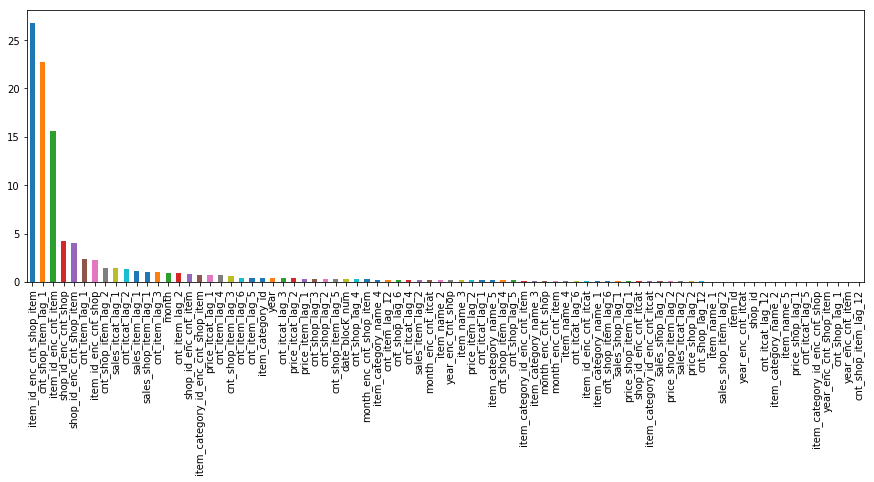

In [62]:
imp = cat1.get_feature_importance(prettified=True)
features = [int(i[0].decode("utf-8")) for i in imp]
features = X_train.columns[features]
pd.Series(data = [i[1] for i in imp], index=features).plot(kind= 'bar')